# 02_DiD_estimates.ipynb

In [16]:
from differences import ATTgt
import figure_utilities
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd


# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_40270/2307055463.py:17: DtypeWarning: Columns (149,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA)


In [17]:
# Store a list of column names containing Zestimates.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]

# Create dictionaries to map between string represetation and integer representation of each month.
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

In [18]:
# Drop rows for which we are missing any Zestimates.
has_all_zestimates_mask = df[value_vars].notna().all(axis=1) 
print(f"Limiting sample to {has_all_zestimates_mask.sum()} evictions for which we observe Zestimates at every month "
      "from 2012-12 to 2022-12.")
df = df.loc[has_all_zestimates_mask, :]

Limiting sample to 3301 evictions for which we observe Zestimates at every month from 2012-12 to 2022-12.


In [19]:
# Reshape from wide to long.
df = pd.melt(df,
             id_vars=['case_number', 'file_date', 'judgment_for_plaintiff'],
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# Get 'first treated' date for each observation.
df.loc[:, 'file_date'] = pd.to_datetime(df['file_date']).dt.strftime('%Y-%m')

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, 'file_date'] = df['file_date'].replace(month_to_int_dictionary)
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, 'file_date'] = np.NaN

# Set index to entity and time.
df = df.set_index(['case_number', 'month'])

file_date  month
77.0       0        156
           1        156
           2        156
           3        156
           4        156
                   ... 
NaN        116      859
           117      859
           118      859
           119      859
           120      859
Name: count, Length: 3146, dtype: int64


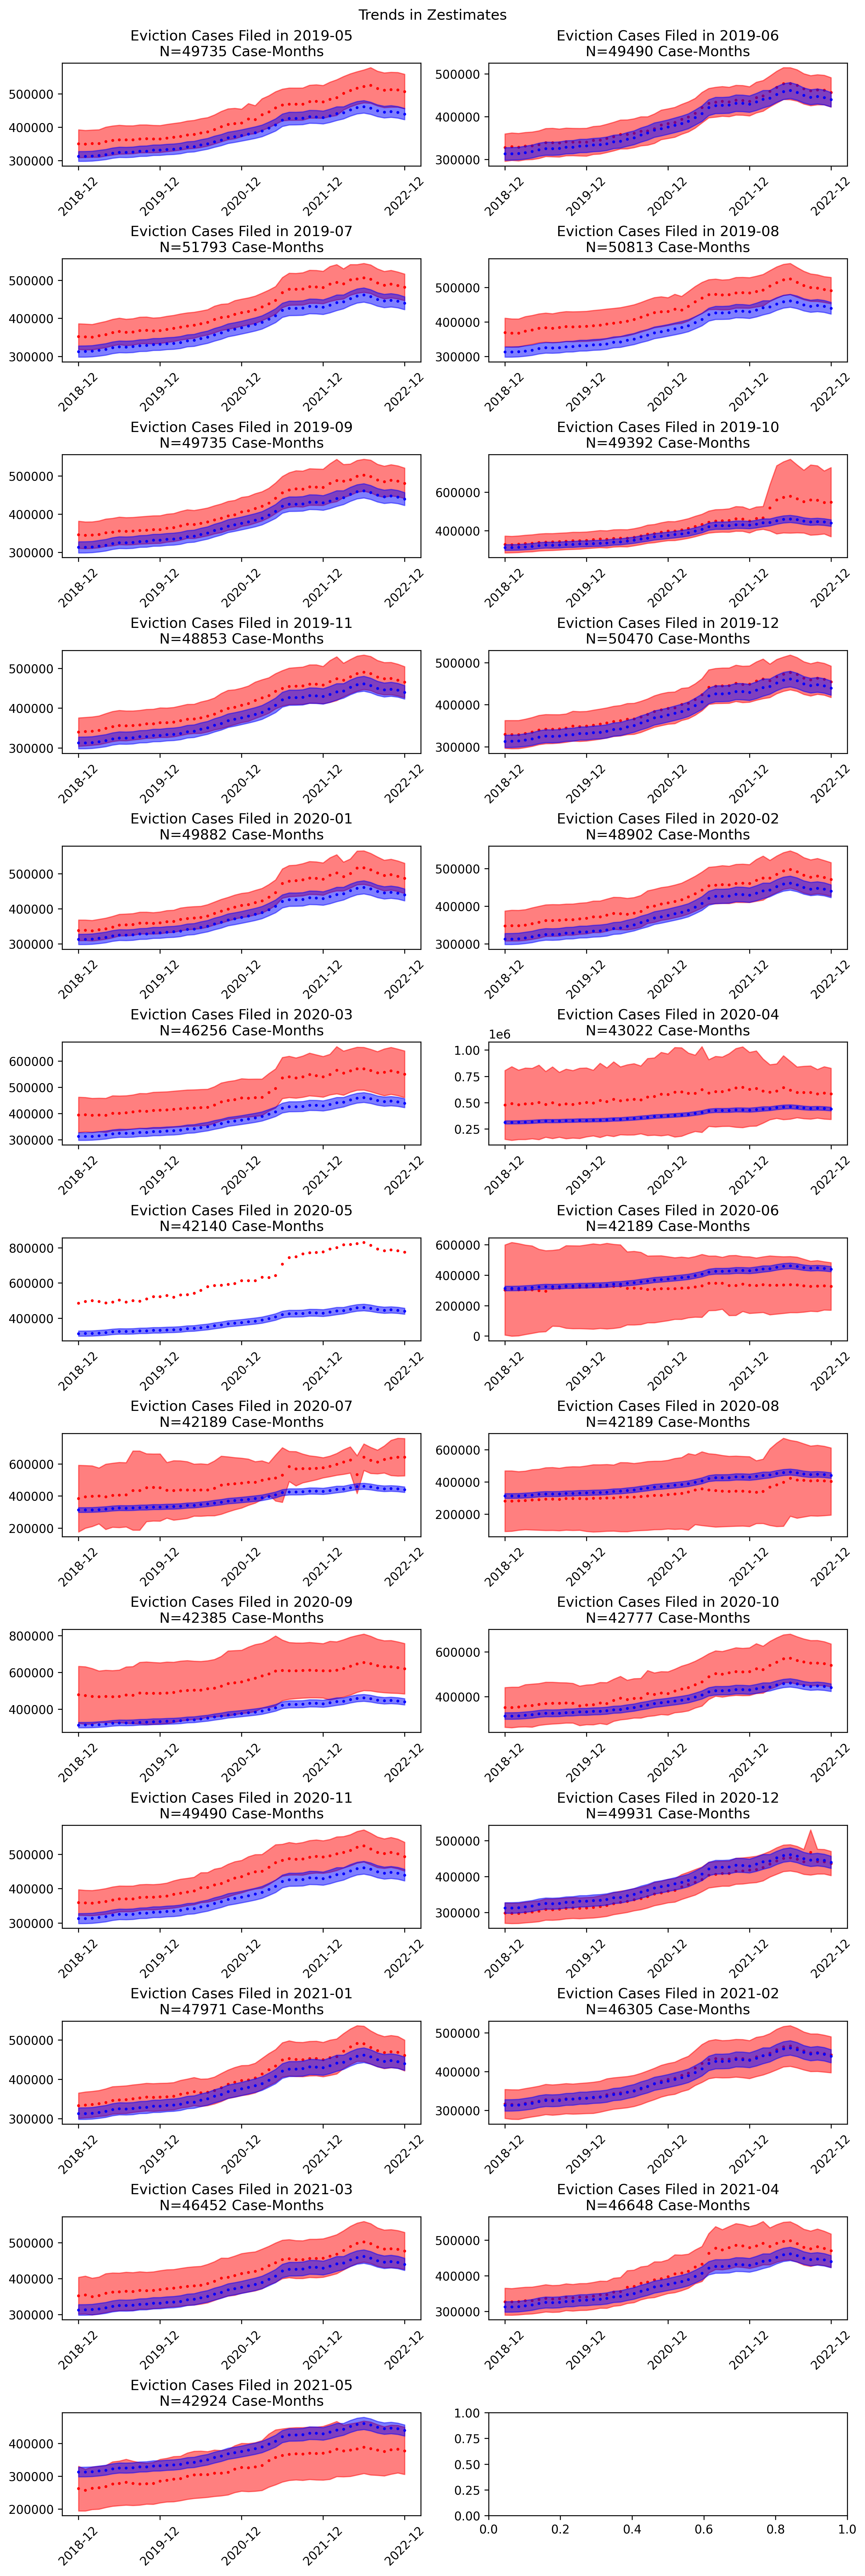

In [20]:
# Plot path of outcomes in treated group vs. control group, separately by cohort.

# Plot.
aggregated_zestimates = df.copy().groupby(['file_date', 'month'], dropna=False)['zestimate'].agg([np.mean, np.std, 'count'])
print(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96*aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96*aggregated_zestimates['se']
aggregated_zestimates = aggregated_zestimates.loc[(slice(None), slice(72, 121)), :]
treatment_times = aggregated_zestimates.index.get_level_values('file_date').unique()

fig, axes = plt.subplots(int(len(treatment_times) / 2), 2, layout='constrained', figsize=(10, 30))
axes = axes.flatten()

for ax, aggregated_cohort in zip(axes, treatment_times):
    if np.isnan(aggregated_cohort):
        continue
    

    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values
    
    
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                              x_treatment,
                                              y_treatment,
                                              y_upper_treatment,
                                              y_lower_treatment,
                                                    point_color='red',
                                                    error_color='red')
    
    sub_df_control = aggregated_zestimates.loc[aggregated_zestimates.index.get_level_values('file_date').isna(), :]
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                              x_control,
                                              y_control,
                                              y_upper_control,
                                              y_lower_control,
                                                    point_color='blue',
                                                    error_color='blue')
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(f"Eviction Cases Filed in {int_to_month_dictionary[aggregated_cohort]}\n"
                 f"N={count_treatment+count_control} Case-Months")
    fig.suptitle("Trends in Zestimates")
plt.show()


In [21]:
# Run DiD.
att_gt = ATTgt(data=df, cohort_name='file_date', freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [01:26<00:00,


In [23]:
# Get cohort-aggregated ATT(t)s.
results_df = att_gt.aggregate('event')
results_df = results_df.loc[-20:5]
results_df.columns = results_df.columns.droplevel().droplevel()
    
# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
x = results_df.index
y = results_df['ATT']
y_upper = results_df['upper']
y_lower = results_df['lower']
ax.grid(True)
ax.set_xlabel("Month Relative to Treatment")
ax.set_ylabel("ATT")
ax.set_title("ATT(g, t) Estimates, Aggregated by Month Relative to Treatment")
figure_utilities.plot_labeled_vline(ax, x=0, text="Last Docket Date")
figure_utilities.plot_labeled_hline(ax, y=0, text="")
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_estimates_event_study.png"))


att_gt.plot('event')